In [1]:
try: 
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns
try:
    import pymc as pm # For MCMC
except:
    !pip install pymc
    import pymc as pm
try:
    import arviz as az # For MCMC package
except:
    !pip install arviz
    import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
try:
    import corner
except:
    !pip install corner
    import corner

print(pm.__version__)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.15.0


In [2]:
def dfg(a,b):
    file_path = 'datasets/Donor%d_CD%d_Genes.csv' %(a,b)
    all_df = pd.read_csv(file_path)
    file_path = 'datasets/mt_genes_metadata.csv'
    dfmeta = pd.read_csv(file_path)
    protein_coding_genes = dfmeta[dfmeta['gene_type'] == 'protein_coding']
    protein_names = protein_coding_genes['gene_name'].tolist()
    df2 = pd.DataFrame([all_df[i] for i in protein_names]).T
    return df2

In [3]:
def normiz_2(df,s_n = 1000):
    df1 = df
    listfinal = [sum(df.iloc[i]) for i in range(len(df))]
    for i in range(len(df)):
        df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
    return df1

In [4]:
def g_log(df_n):
    df_final = normiz_2(df_n).T
    gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
    gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
    log_gene_mean = np.log(gene_mean)
    log_gene_var = np.log(gene_var)
    return log_gene_mean, log_gene_var

def log_gene_plot(df_n):
    df_final = normiz_2(df_n).T
    gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
    gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
    log_gene_mean = np.log(gene_mean)
    log_gene_var = np.log(gene_var)
    plt.scatter(log_gene_mean,log_gene_var)

In [5]:
def lse(a,b):
    x = g_log(normiz_2(dfg(a,b)))[0]
    y = g_log(normiz_2(dfg(a,b)))[1]

    X = np.vstack([np.ones(len(x)), x]).T
    # theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    a, b = theta
    print(f"Estimated parameters: a = {a}, b = {b}")

    y_pred = a + b * x

    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)

    print(f"R-squared (R^2) value: {r_squared}")

    plt.scatter(x, y, label='Observed data')
    plt.plot(x, y_pred, color='red', label='Fitted line')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Least Squares Estimation')
    plt.legend()
    plt.show()

---

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import nbinom, chisquare
def negative_binomial_gof(data, bins=None):
    """
    Perform a goodness-of-fit test to check if the data follows a negative binomial distribution.
    
    Parameters:
    - data: array-like, the observed data to test
    - bins: int or None, number of bins to group the data into for stabilization
    
    Returns:
    - chi_square_stat: float, the chi-square statistic
    - p_value: float, the p-value of the chi-square test
    - r: float, estimated parameter r (number of successes)
    - p: float, estimated parameter p (probability of success)
    """
    # Ensure data is a numpy array
    
    
    # Step 1: Calculate mean and variance of the data
    mean = np.mean(data)
    variance = np.var(data)
    
    # Step 2: Estimate the parameters r and p
    if variance <= mean:
        raise ValueError("Variance must be greater than the mean for a negative binomial distribution.")
    
    r = mean**2 / (variance - mean)
    p = mean / variance
    print(f"Estimated parameters: r = {r}, p = {p}")
    
    # Step 3: Create observed frequency table
    if bins is None:
        observed_freq = pd.Series(data).value_counts().sort_index()
    else:
        observed_freq, bin_edges = np.histogram(data, bins=bins)
        observed_freq = pd.Series(observed_freq, index=bin_edges[:-1])
    
    # Step 4: Calculate expected frequencies
    expected_freq = []
    for k in observed_freq.index:
        prob = nbinom.pmf(k, r, p)
        expected_freq.append(prob * len(data))
    
    # Convert to numpy arrays for the chi-square test
    observed_freq = observed_freq.values
    expected_freq = np.array(expected_freq)
    
    # Normalize expected frequencies to sum to observed frequencies
    expected_freq_sum = expected_freq.sum()
    observed_freq_sum = observed_freq.sum()
    expected_freq = expected_freq * (observed_freq_sum / expected_freq_sum)
    
    # Ensure no zero expected frequencies
    expected_freq = np.where(expected_freq == 0, 1e-10, expected_freq)
    
    print("Observed frequencies:\n", observed_freq)
    print("Expected frequencies:\n", expected_freq)
    
    # Step 5: Perform the chi-square goodness of fit test
    chi_square_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Output results
    print(f"Chi-Square Statistic: {chi_square_stat}")
    print(f"p-value: {p_value}")
    
    # Interpretation
    if p_value < 0.05:
        print("Reject the null hypothesis: The data does not follow a negative binomial distribution.")
    else:
        print("Fail to reject the null hypothesis: The data could follow a negative binomial distribution.")
    
    return chi_square_stat, p_value, r, p

In [7]:
negative_binomial_gof(dfg(1,4)["MT-ND1"])

Estimated parameters: r = 3.619771220237506, p = 0.3161248033764885
Observed frequencies:
 [ 54 101 161 200 250 260 293 253 250 209 155 143 120  91  71  50  56  37
  31  30  16  12   9  10   6   3   4   2   2   2   2   1   1   1   1   1]
Expected frequencies:
 [4.47119735e+01 1.10683228e+02 1.74843359e+02 2.23987290e+02
 2.53503066e+02 2.64199503e+02 2.59569308e+02 2.43947794e+02
 2.21461849e+02 1.95537853e+02 1.68755982e+02 1.42893725e+02
 1.19055466e+02 9.78267236e+01 7.94202714e+01 6.37994927e+01
 5.07748251e+01 4.00747024e+01 3.13948560e+01 2.44305274e+01
 1.88959141e+01 1.45345353e+01 1.11234456e+01 8.47351495e+00
 6.42737338e+00 4.85613163e+00 3.65561216e+00 2.74255219e+00
 2.05104724e+00 1.52937238e+00 1.13723378e+00 8.43450623e-01
 6.24037562e-01 1.33990631e-01 9.79501624e-02 2.04436265e-03]
Chi-Square Statistic: 527.9836959516026
p-value: 2.519434889002617e-89
Reject the null hypothesis: The data does not follow a negative binomial distribution.


(527.9836959516026,
 2.519434889002617e-89,
 3.619771220237506,
 0.3161248033764885)

In [8]:
np.mean(normiz_2(dfg(1,4))["MT-ND1"])

48.12274271988561

In [9]:
def negative_binomial_gof(data, bins=None):
    """
    Perform a goodness-of-fit test to check if the data follows a negative binomial distribution.
    
    Parameters:
    - data: array-like, the observed data to test
    - bins: int or None, number of bins to group the data into for stabilization
    
    Returns:
    - chi_square_stat: float, the chi-square statistic
    - p_value: float, the p-value of the chi-square test
    - r: float, estimated parameter r (number of successes)
    - p: float, estimated parameter p (probability of success)
    """
    # Ensure data is a numpy array
    
    
    # Step 1: Calculate mean and variance of the data
    mean = np.mean(data)
    variance = np.var(data)
    
    # Step 2: Estimate the parameters r and p
    if variance <= mean:
        raise ValueError("Variance must be greater than the mean for a negative binomial distribution.")
    
    r = mean**2 / (variance - mean)
    p = mean / variance
    # print(f"Estimated parameters: r = {r}, p = {p}")
    
    # Step 3: Create observed frequency table
    if bins is None:
        observed_freq = pd.Series(data).value_counts().sort_index()
    else:
        observed_freq, bin_edges = np.histogram(data, bins=bins)
        observed_freq = pd.Series(observed_freq, index=bin_edges[:-1])
    
    # Step 4: Calculate expected frequencies
    expected_freq = []
    for k in observed_freq.index:
        prob = nbinom.pmf(k, r, p)
        expected_freq.append(prob * len(data))
    
    # Convert to numpy arrays for the chi-square test
    observed_freq = observed_freq.values
    expected_freq = np.array(expected_freq)
    
    # Normalize expected frequencies to sum to observed frequencies
    expected_freq_sum = expected_freq.sum()
    observed_freq_sum = observed_freq.sum()
    expected_freq = expected_freq * (observed_freq_sum / expected_freq_sum)
    
    # Ensure no zero expected frequencies
    expected_freq = np.where(expected_freq == 0, 1e-10, expected_freq)
    
    # print("Observed frequencies:\n", observed_freq)
    # print("Expected frequencies:\n", expected_freq)
    
    # Step 5: Perform the chi-square goodness of fit test
    chi_square_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Output results
    # print(f"Chi-Square Statistic: {chi_square_stat}")
    # print(f"p-value: {p_value}")
    
    # Interpretation
    if p_value < 0.05:
        print("Reject the null hypothesis: The data does not follow a negative binomial distribution.")
    else:
        print("Fail to reject the null hypothesis: The data could follow a negative binomial distribution.")
    
    return chi_square_stat, p_value, r, p

Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does not follow a negative binomial distribution.
Reject the null hypothesis: The data does n

(array([7.660e+02, 1.265e+03, 5.800e+02, 2.040e+02, 5.300e+01, 1.300e+01,
        4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

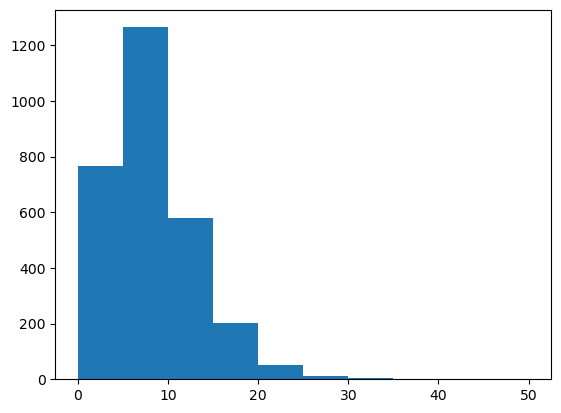

In [23]:
plt.hist(dfg(1,4).T.iloc[0].values)

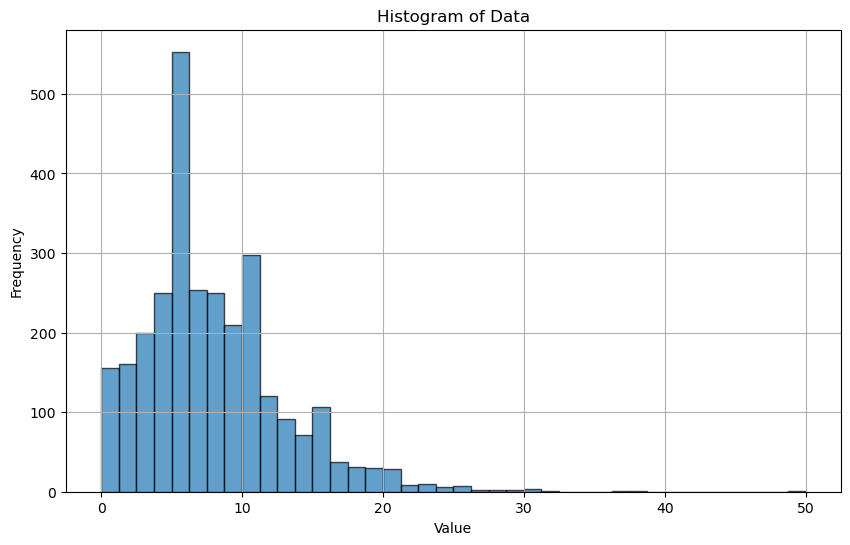

In [28]:
import matplotlib.pyplot as plt
data = dfg(1,4).T.iloc[0].values
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=40, edgecolor='k', alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [18]:
dfg(1,4)

MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP8  MT-ATP6  MT-CO3  MT-ND3  \
0         12       3      23      53       34        3      38       6   
1          8       4      24      35       10        2      34       3   
2          7       2      16      30        8        1      19       6   
3          3       2      25      23       14        5      23       2   
4          6       3       6      26       14        1      11       4   
...      ...     ...     ...     ...      ...      ...     ...     ...   
2883       4       0      20      15       11        3      11       2   
2884       2       5      13      28       12        2      18       6   
2885       5       0      10      22       13        1      14       4   
2886       6      12      36      45       19        2      40       5   
2887       7       1       9      24       11        0      22       1   

      MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  
0          20       5       7       7      20  
1          15       7       6       1      17  
2          20       3       7       0      15  
3          13       4       6       3      14  
4          14       0       2       0       7  
...       ...     ...     ...     ...     ...  
2883        5       2       3       0       4  
2884       14       2       2       1       8  
2885        6       7       5       1      20  
2886       20       8       7       0      37  
2887        7       2       7       1      17  

[2888 rows x 13 columns]

c:\Users\ruizc\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


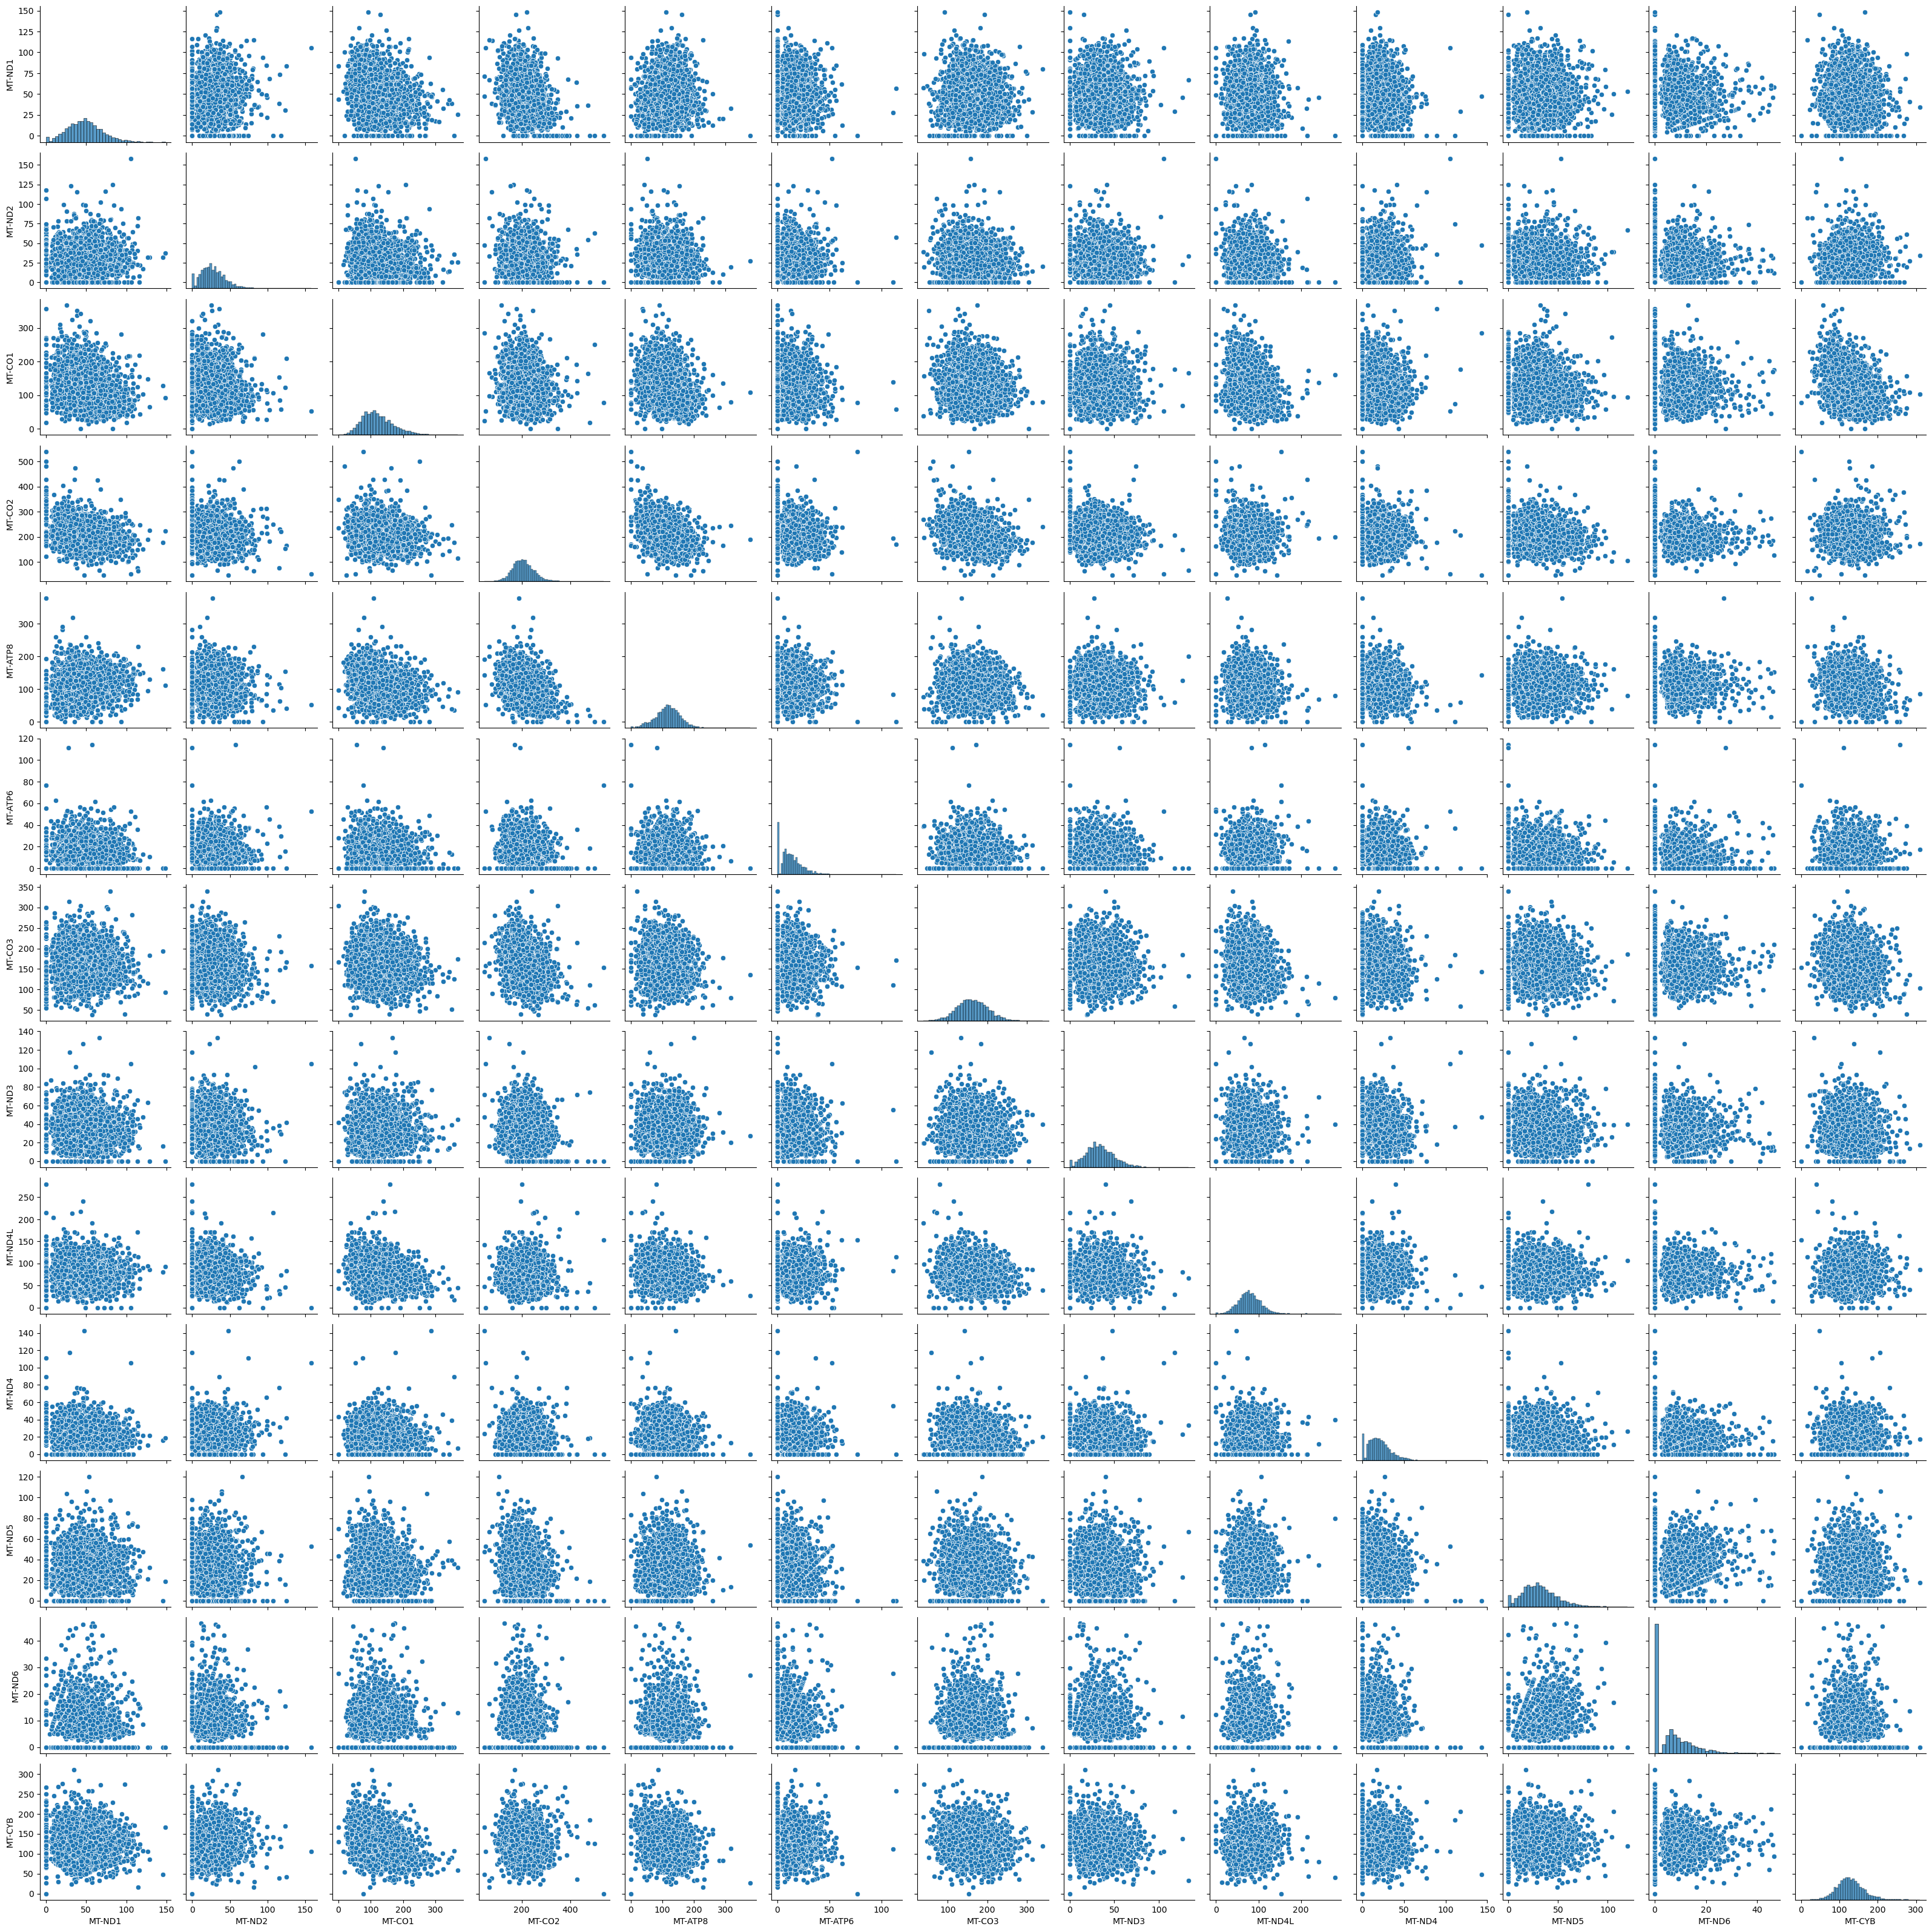

In [30]:
sns.pairplot(normiz_2(dfg(1,4)))

c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

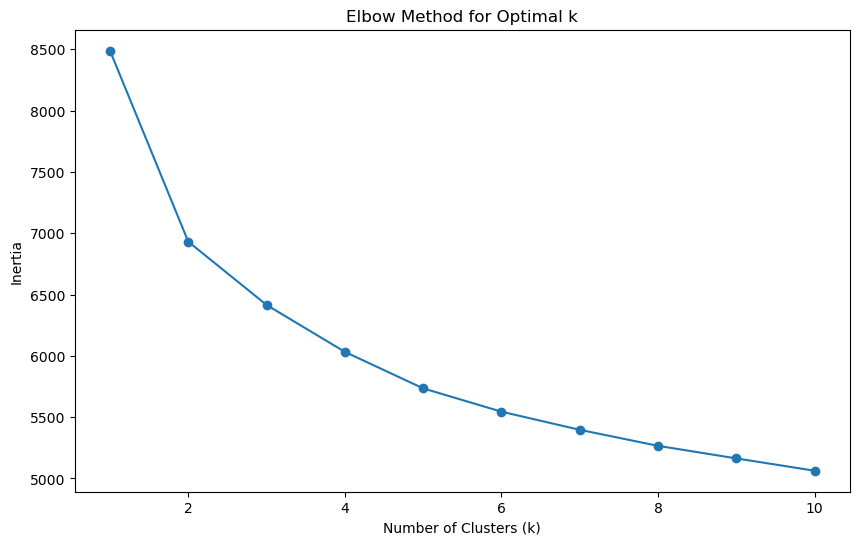

c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


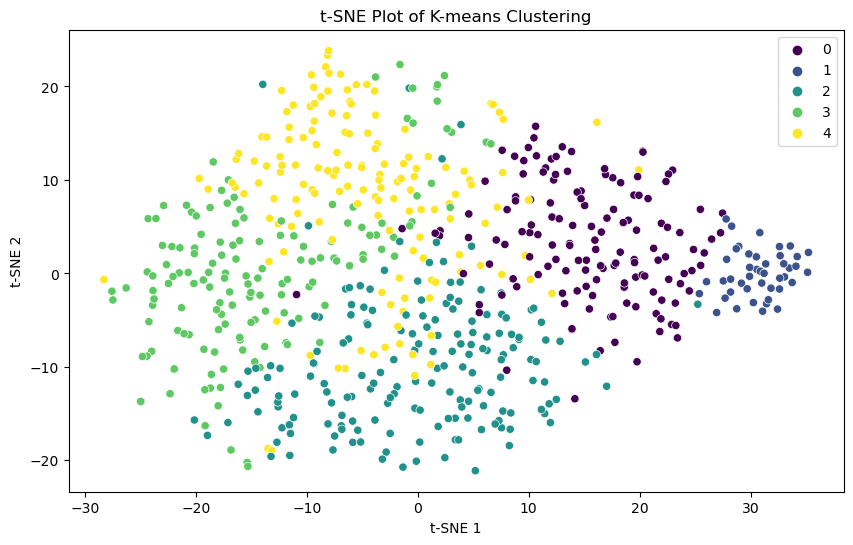

ValueError: Length of values (653) does not match length of index (2888)

In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = dfg(1,4) # Adjust path and index_col as necessary

# Quality control (example: remove cells with fewer than 200 genes or more than 2500 genes)
filtered_data = data.loc[data.sum(axis=1) > 200, data.sum(axis=0) > 5]

# Normalize the data (log normalization)
normalized_data = np.log1p(filtered_data)

# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(normalized_data)

# Dimensionality reduction using PCA
pca = PCA(n_components=13)  # Reduce to 50 principal components
pca_data = pca.fit_transform(standardized_data)

# Determine the number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Assume we choose 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(pca_data)

# Reduce dimensions to 2 for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(pca_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE Plot of K-means Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Add cluster labels to the data for easier analysis
data['Cluster'] = clusters

# Analyze marker genes for each cluster
cluster_means = data.groupby('Cluster').mean()
print(cluster_means)


c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

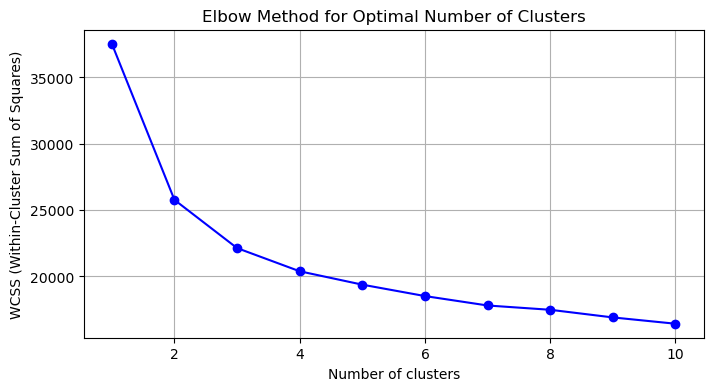

c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


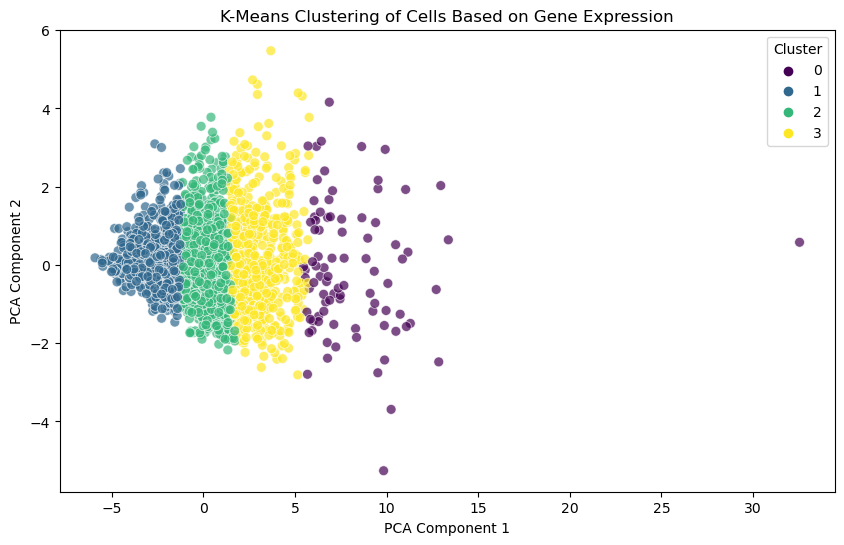

Cluster Centers (Mean Expression Levels):
          0         1          2          3          4         5          6   \
0  19.659091  9.931818  47.500000  76.113636  46.409091  5.386364  61.318182   
1   4.243133  2.478128  12.441506  20.171923  10.245168  1.170905  15.492370   
2   7.672830  4.448553  19.353698  33.235531  19.524920  2.132637  26.721865   
3  12.511344  7.062827  26.636998  46.001745  29.357766  3.155323  38.075044   

          7          8         9          10        11         12  
0  13.556818  28.909091  7.886364  11.977273  2.693182  45.443182  
1   3.006104   7.499491  1.777213   2.737538  0.507630  12.196338  
2   5.622990  12.683280  3.371383   4.946945  0.951768  20.161576  
3   8.326353  18.308901  4.712042   8.080279  1.799302  30.446771  


In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



# Extracting only the gene expression data
X = dfg(1,4)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of clusters using the Elbow method
# This is optional, and you may already know the desired number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Select the number of clusters
# Choose the appropriate number of clusters based on the elbow method or prior knowledge
n_clusters = 4

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original dataset
data['Cluster'] = clusters

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

# Add the PCA components to the dataset for plotting
data['PCA1'] = pca_data[:, 0]
data['PCA2'] = pca_data[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis', s=50, alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering of Cells Based on Gene Expression')
plt.legend(title='Cluster')
plt.show()

# Display cluster centers (mean expression levels of each gene per cluster)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers)
print("Cluster Centers (Mean Expression Levels):")
print(cluster_centers_df)

# # Save clustered data to a CSV file
# data.to_csv('clustered_data.csv', index=False)
# print("Clustered data saved to 'clustered_data.csv'")


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace 'your_data.csv' with the actual file path)
data = pd.read_csv('datasets\Donor1_CD4_Genes.csv')

# Inspect the first few rows
print(data.head())

# Assuming the columns are named 'Gene1', 'Gene2', ..., 'Gene13'
genes = ['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

# Extract the gene expression data
X = data[genes].values

# Standardize the data to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering to identify homogeneous groups
n_clusters = 3  # You can choose the number of clusters based on your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original data
data['Cluster'] = clusters

# Normalize within each cluster
normalized_data = pd.DataFrame()
for cluster in range(n_clusters):
    cluster_data = data[data['Cluster'] == cluster][genes]
    cluster_scaled = scaler.fit_transform(cluster_data)  # Re-scale within cluster
    normalized_cluster = pd.DataFrame(cluster_scaled, columns=genes)
    normalized_cluster['Cluster'] = cluster
    normalized_data = pd.concat([normalized_data, normalized_cluster])

# Reset the index for the combined DataFrame
normalized_data.reset_index(drop=True, inplace=True)

# Display the first few rows of normalized data
print(normalized_data.head())

# Optional: Save the normalized data
normalized_data.to_csv('normalized_data.csv', index=False)
print("Normalized data saved to 'normalized_data.csv'")


           Unnamed: 0  MT-TF  MT-RNR1  MT-TV  MT-RNR2  MT-TL1  MT-ND1  MT-TI  \
0  AAACCTGCAAACTGTC.1      0        6      0       60       0      12      0   
1  AAACCTGCACAGCGTC.1      0        2      0       21       0       8      0   
2  AAACGGGAGACTGGGT.1      0       19      0       84       0       7      0   
3  AAACGGGAGGTGTTAA.1      0       27      0      115       0       3      0   
4  AAACGGGCATGGGACA.1      0       43      1      119       0       6      0   

   MT-TQ  MT-TM  ...  MT-TH  MT-TS2  MT-TL2  MT-ND5  MT-ND6  MT-TE  MT-CYB  \
0      0      0  ...      0       0       0       7       7      0      20   
1      0      0  ...      0       0       0       6       1      0      17   
2      0      0  ...      0       0       0       7       0      0      15   
3      0      0  ...      0       0       0       6       3      0      14   
4      0      0  ...      0       0       0       2       0      0       7   

   MT-TT  MT-TP  non-MT  
0      0      0    1250 

c:\Users\ruizc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


     MT-ND1    MT-ND2    MT-CO1    MT-CO2   MT-ATP8   MT-ATP6    MT-CO3  \
0 -0.180886 -0.383780  0.325235 -0.106387 -1.694987 -0.235592  0.562779   
1 -1.586076 -1.162833  0.433061 -1.501053 -1.111337  1.641375 -0.751671   
2 -0.461924 -1.552359  2.373922  1.985612 -0.527687  1.015719  1.996724   
3 -0.461924 -0.773307 -0.537370 -0.571275  1.077351 -0.861248 -0.393184   
4 -0.742962  0.395272 -1.507801 -0.455053  0.785526 -1.486904 -0.512680   

     MT-ND3   MT-ND4L    MT-ND4    MT-ND5    MT-ND6    MT-CYB  Cluster  
0 -1.182653  0.226286  1.590630  0.144783 -0.113365 -0.863896        0  
1 -1.553636 -0.228759  0.143786  0.144783  1.536506 -1.343508        0  
2 -0.440686  0.908853  1.108348  0.877517 -0.938300  3.132865        0  
3 -0.069703 -0.456282  1.590630  0.877517 -0.113365 -0.224414        0  
4 -0.440686 -0.001237 -0.338496 -0.954317 -0.938300 -0.384285        0  
Normalized data saved to 'normalized_data.csv'


In [39]:
normalized_data

MT-ND1    MT-ND2    MT-CO1    MT-CO2   MT-ATP8   MT-ATP6    MT-CO3  \
0    -0.180886 -0.383780  0.325235 -0.106387 -1.694987 -0.235592  0.562779   
1    -1.586076 -1.162833  0.433061 -1.501053 -1.111337  1.641375 -0.751671   
2    -0.461924 -1.552359  2.373922  1.985612 -0.527687  1.015719  1.996724   
3    -0.461924 -0.773307 -0.537370 -0.571275  1.077351 -0.861248 -0.393184   
4    -0.742962  0.395272 -1.507801 -0.455053  0.785526 -1.486904 -0.512680   
...        ...       ...       ...       ...       ...       ...       ...   
2883  0.833475  1.054952 -0.612260  0.314907 -0.228210  1.322820  0.246659   
2884 -1.109120 -0.396183  2.042709  0.517952  1.274330  0.055862  0.121340   
2885 -0.755921 -0.686410 -0.216839 -0.446511 -0.404980  0.478182  0.309318   
2886 -1.285720  0.474498 -0.781726  0.264146 -0.139826  0.055862 -0.003978   
2887  0.656876 -0.396183 -0.555771 -0.751078 -0.316595 -0.788776 -0.442594   

        MT-ND3   MT-ND4L    MT-ND4    MT-ND5    MT-ND6    MT-CYB  Cluster  
0    -1.182653  0.226286  1.590630  0.144783 -0.113365 -0.863896        0  
1    -1.553636 -0.228759  0.143786  0.144783  1.536506 -1.343508        0  
2    -0.440686  0.908853  1.108348  0.877517 -0.938300  3.132865        0  
3    -0.069703 -0.456282  1.590630  0.877517 -0.113365 -0.224414        0  
4    -0.440686 -0.001237 -0.338496 -0.954317 -0.938300 -0.384285        0  
...        ...       ...       ...       ...       ...       ...      ...  
2883  0.695301  0.017673 -0.264466  0.347462  0.501834 -0.348184        2  
2884  2.715082 -0.408727 -0.608000 -1.170926 -0.081838  0.061189        2  
2885 -0.314589  0.728339  0.079067  1.106656 -1.249181  0.368219        2  
2886 -0.567061  0.017673  0.422601 -1.677055  0.501834  0.163533        2  
2887 -0.314589 -0.408727 -1.295067  0.600526 -0.081838 -0.757557        2  

[2888 rows x 14 columns]

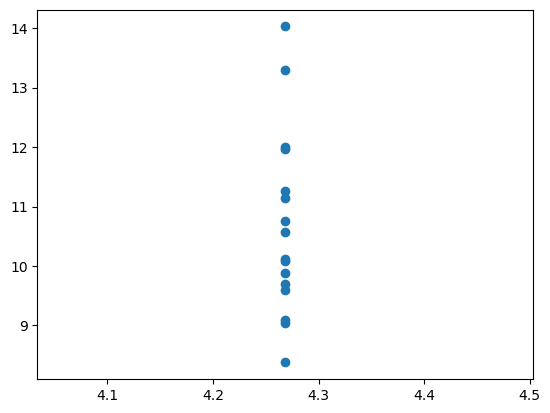

In [48]:
norm_mean = [np.mean(normalized_data.iloc[i]) for i in range(13)]
norm_var = [np.var(normalized_data.iloc[i]) for i in range(13)]
plt.scatter(np.log(norm_mean),np.log(norm_var))

c:\Users\ruizc\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


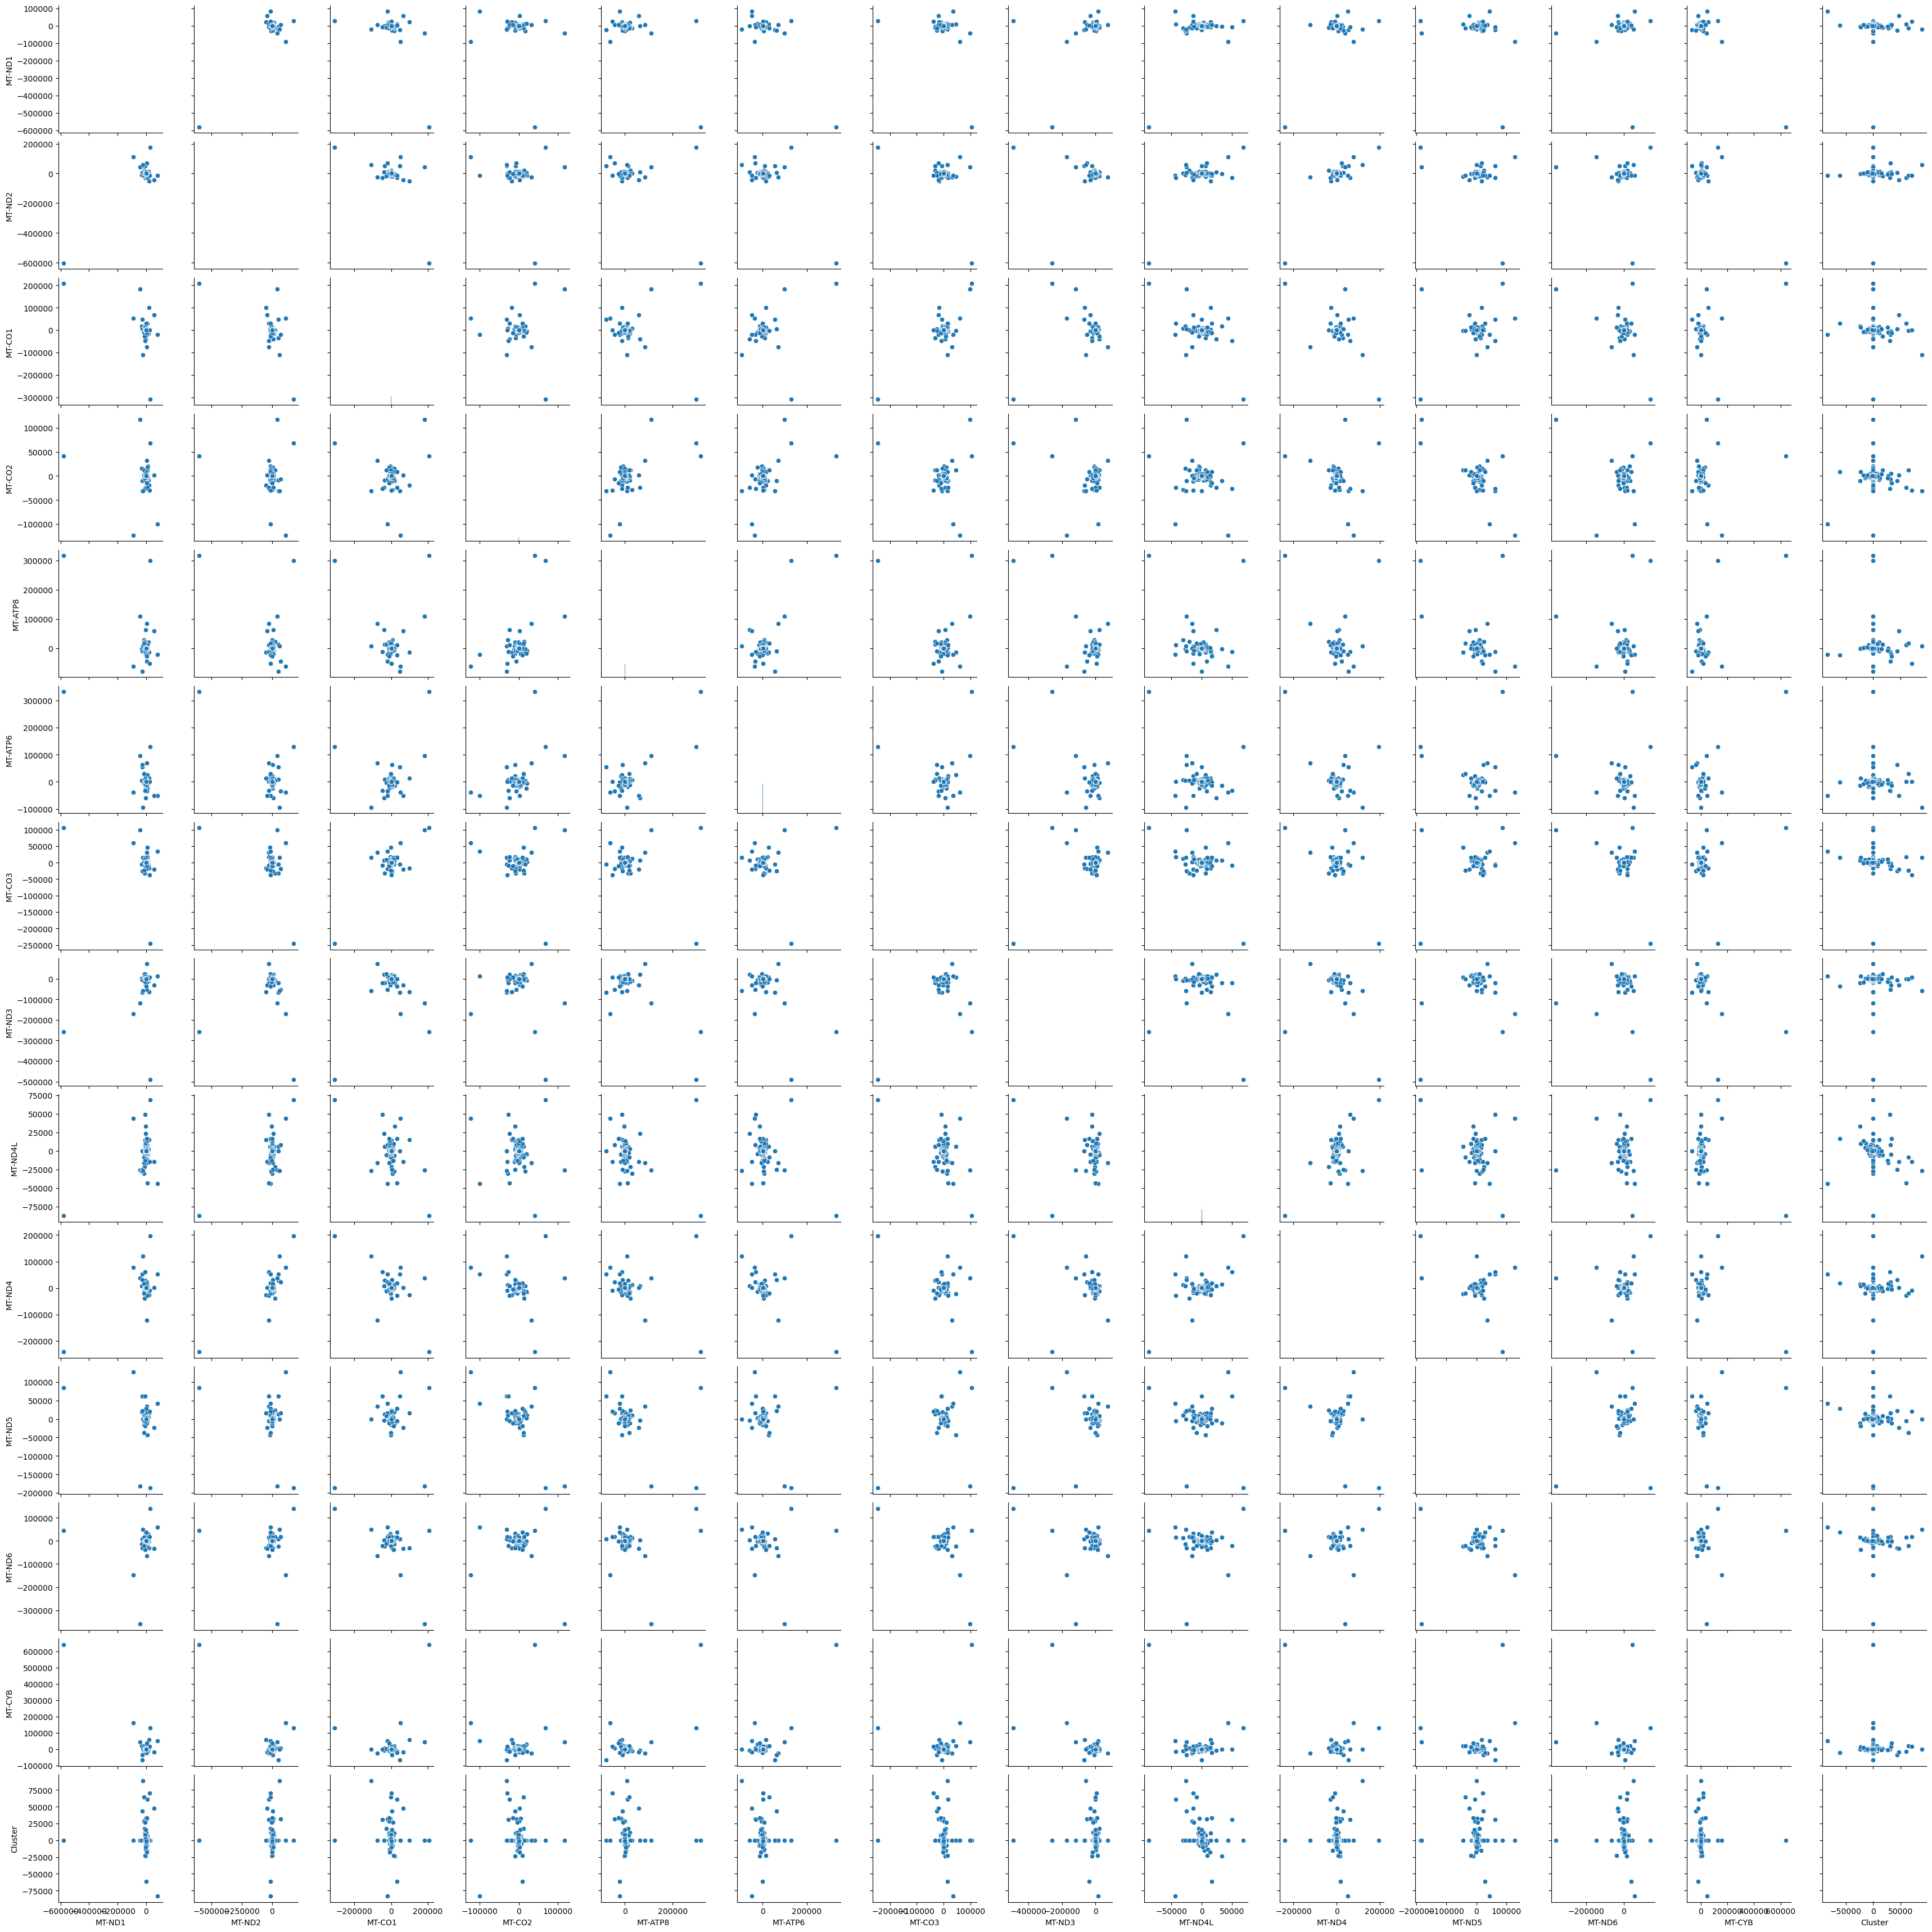

In [49]:
sns.pairplot(normalized_data)